In [55]:
import os
import glob
import nibabel as nb
import scipy.stats
import numpy as np
from brainspace.mesh.mesh_io import read_surface
from brainspace.plotting import plot_hemispheres
from brainspace.gradient import GradientMaps
from brainspace.mesh.array_operations import smooth_array
from brainspace.plotting import plot_hemispheres
from brainspace.mesh.mesh_creation import build_polydata
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import copy

In [56]:
# Path to MICAPIPEsurf = mask_5k !
micapipe=os.popen("echo $MICAPIPE").read()[:-1]

# Load native mid surface
inf_lh = read_surface(micapipe + '/surfaces/fsLR-5k.L.inflated.surf.gii', itype='gii')
inf_rh = read_surface(micapipe + '/surfaces/fsLR-5k.R.inflated.surf.gii', itype='gii')

mask_lh =  nb.load(micapipe + '/surfaces/fsLR-5k.R.mask.shape.gii').darrays[0].data
mask_rh =  nb.load(micapipe + '/surfaces/fsLR-5k.L.mask.shape.gii').darrays[0].data
mask_5k = np.concatenate((mask_lh, mask_rh), axis=0)

sphere_lh = read_surface(micapipe+'/surfaces/fsLR-5k.L.sphere.surf.gii', itype='gii')
sphere_rh = read_surface(micapipe+'/surfaces/fsLR-5k.R.sphere.surf.gii', itype='gii')

## Create a brain mask derived from the thickness

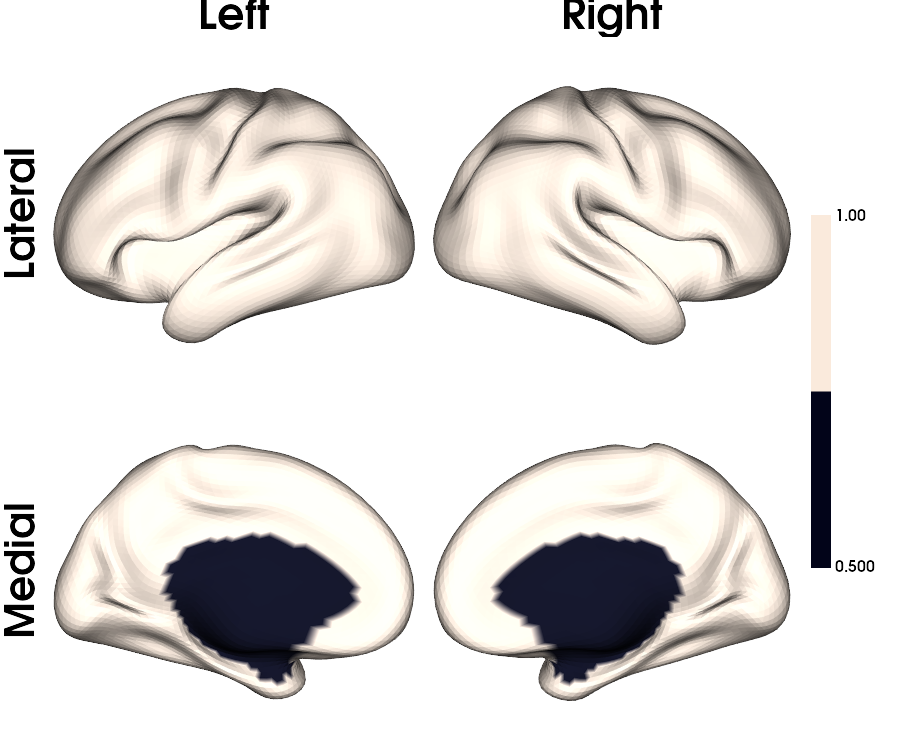

In [57]:
# Set dataset PNI as working directory
os.chdir('/data_/mica3/BIDS_PNI/derivatives/micapipe_v0.2.0')

# Load thickness to make a better mask
lh_files = sorted(glob.glob('sub-PNC*/ses-01/maps/*_hemi-L_surf-fsLR-5k_label-thickness.func.gii'))
rh_files = sorted(glob.glob('sub-PNC*/ses-01/maps/*_hemi-R_surf-fsLR-5k_label-thickness.func.gii'))

# Load all the thickness data
Nth=np.concatenate((nb.load(lh_files[0]).darrays[0].data, nb.load(rh_files[0]).darrays[0].data), axis=0).shape[0]

surf_map=np.empty([len(lh_files), Nth], dtype=float)
for i, _ in enumerate(lh_files):
    surf_map[i,:] = np.hstack(np.concatenate((nb.load(lh_files[i]).darrays[0].data, nb.load(rh_files[i]).darrays[0].data), axis=0))
    # Mean matrix across the x axis (vertices)
    map_mean = np.mean(surf_map, axis=0)

#mask_5k = np.where(map_mean<0.3,False, True)
plot_hemispheres(inf_lh, inf_rh, array_name=mask_5k, cmap='rocket', nan_color=(0, 0, 0, 1),
                              zoom=1.3, size=(900, 750), embed_nb=True,
                              color_bar='right', layout_style='grid', color_range=(0.5,1),
                              label_text={'left': ['Lateral', 'Medial'], 'top': ['Left', 'Right']},
                              screenshot=False)

## fsLR-5k qMRI maps

In [58]:
# load stuff
from brainspace.datasets import load_mask
mask_32k = load_mask(join=True)

# Labels and boolean mask
mask_surf = mask_5k != 0

inf5_lh = read_surface(micapipe + '/surfaces/fsLR-5k.L.inflated.surf.gii', itype='gii')
inf5_rh = read_surface(micapipe + '/surfaces/fsLR-5k.R.inflated.surf.gii', itype='gii')

In [59]:
# Smooth intencities
def smooth_surf(surf_l, surf_r, points, Mask, Kernel='uniform', Niter=3, Relax=0.35):
    '''
    This function smooth an array (left and right) on a given surface
    Parameters
    ----------
    surf_l : np.array left surface 
    surf_r : np.array right surface
    points : np.array surface data
    Kernel : {'uniform', 'gaussian', 'inverse_distance'}
    Niter  : int, optional Number of smooth iterations
    Relax  : relax : float, optional relaxation factor
    Mask   : str or 1D ndarray, optional
    Returns
    -------
    sdata : smoothed numpy array
    
    '''
    Ndim = Mask.shape[0] 
    n2dim = int(Ndim/2)
    Mask_l=Mask[0:n2dim]
    Mask_r=Mask[n2dim:Ndim]
    sdata = np.concatenate((smooth_array(surf_l, points[0:n2dim],kernel=Kernel, n_iter=Niter,relax=Relax, mask=Mask_l), 
                          smooth_array(surf_r, points[n2dim:Ndim],kernel=Kernel, n_iter=Niter,relax=Relax, mask=Mask_r)), axis=0)
    return(sdata)

# Smooth each intencity
def smooth_intensities(int_profile):
    smoothed_i = np.copy(int_profile)
   
    # smooth each intensity
    for i in range(int_profile.shape[0]):
        smoothed_i[i,:] = smooth_surf(inf_lh, inf_rh, int_profile[i,:], mask_surf,Niter=5, Relax=0.5, Kernel='uniform')
   
    return(smoothed_i)

## Microstructural profile by SWM depth

In [60]:
def load_qmri_intensity(qmri=''):

    # Load CSV file containing subject and session information
    csv_dir = '/data/mica1/03_projects/youngeun/lists'
    csv_file = f"10PNC_{qmri}.csv"
    subject_session_info = pd.read_csv(csv_dir + '/' + csv_file, header=None, names=['info'], delimiter=',')

    # Extract subject and session information from each row
    files = []
    for index, row in subject_session_info.iterrows():
        info = row['info'].split(',')
        subject = index[4:]  # Extract subject ID
        session = info[0][4:].strip()  # Extract session ID
        file_path = f"sub-{subject}/ses-{session}/mpc-swm/acq-{qmri}/*_surf-fsLR-5k_desc-intensity_profiles.shape.gii"
        files.extend(glob.glob(file_path))
    
    # Print the file paths
    print("Files used:")
    for file_path in files:
        print(file_path)
    
    # Load intensity profiles from each file
    profiles = []
    for file_path in files:
        profile_data = nb.load(file_path).darrays[0].data
        # Smooth each intensity
        profile_data_i = smooth_intensities(profile_data)
        # Replace values in midwall with NaN where mask_10k is False
        profile_data_i[:, mask_5k == False] = np.nan
        #profile_data_i = profile_data_i[1:]
        profiles.append(profile_data_i)
    
    profiles = np.array(profiles)

    # Extract subject and session information
    subjects = set()
    for file_path in files:
        parts = file_path.split('/')
        subject = parts[0][4:]  # Extract subject ID from the directory name
        subjects.add(subject)

    print(f"Intensity Profiles of {qmri} maps - Number of subjects: {len(subjects)}")

    return profiles

In [61]:
def process_qmri_profiles():
    # List of qmri values
    qmri_values = ['T1map', 'MTSAT', 'FA', 'ODI']
    
    # Initialize variables to store each matrix
    T1map = None
    MTSAT = None
    T2star = None
    FA = None
    fod_tournier_afd = None

    # Load data and store matrices for each qmri value
    for qmri in qmri_values:
        # Load intensity profiles for the given qmri value
        profiles = load_qmri_intensity(qmri)
        # Store the matrix
        if qmri == 'T1map':
            T1map = profiles
        elif qmri == 'MTSAT':
            MTSAT = profiles
        elif qmri == 'FA':
            FA = profiles
        elif qmri == 'ODI':
            ODI = profiles

    return T1map, MTSAT, FA, ODI

# Call the function to load profiles for each qmri value and store them as matrices
T1map, MTSAT, FA, ODI = process_qmri_profiles()
# Check the size of each matrix
print(f"T1map: {T1map.shape}")
print(f"MTSAT: {MTSAT.shape}")
print(f"FA: {FA.shape}")
print(f"ODI: {ODI.shape}")

Files used:
sub-PNC003/ses-03/mpc-swm/acq-T1map/sub-PNC003_ses-03_surf-fsLR-5k_desc-intensity_profiles.shape.gii
sub-PNC006/ses-03/mpc-swm/acq-T1map/sub-PNC006_ses-03_surf-fsLR-5k_desc-intensity_profiles.shape.gii
sub-PNC007/ses-03/mpc-swm/acq-T1map/sub-PNC007_ses-03_surf-fsLR-5k_desc-intensity_profiles.shape.gii
sub-PNC009/ses-03/mpc-swm/acq-T1map/sub-PNC009_ses-03_surf-fsLR-5k_desc-intensity_profiles.shape.gii
sub-PNC010/ses-03/mpc-swm/acq-T1map/sub-PNC010_ses-03_surf-fsLR-5k_desc-intensity_profiles.shape.gii
sub-PNC015/ses-03/mpc-swm/acq-T1map/sub-PNC015_ses-03_surf-fsLR-5k_desc-intensity_profiles.shape.gii
sub-PNC016/ses-03/mpc-swm/acq-T1map/sub-PNC016_ses-03_surf-fsLR-5k_desc-intensity_profiles.shape.gii
sub-PNC018/ses-03/mpc-swm/acq-T1map/sub-PNC018_ses-03_surf-fsLR-5k_desc-intensity_profiles.shape.gii
sub-PNC019/ses-03/mpc-swm/acq-T1map/sub-PNC019_ses-03_surf-fsLR-5k_desc-intensity_profiles.shape.gii
sub-PNC022/ses-03/mpc-swm/acq-T1map/sub-PNC022_ses-03_surf-fsLR-5k_desc-intensi

## Average Intensity Profies

In [62]:
## Average Intensity Profies
# Calculate mean matrix for each dataset
mean_T1map = np.mean(T1map, axis=0)
mean_MTSAT = np.mean(MTSAT, axis=0)
mean_FA = np.mean(FA, axis=0)
mean_ODI = np.mean(ODI, axis=0)

# Concatenate mean matrices horizontally
mean_R1 = 1/mean_T1map

# Check the shape of mean matrices
print(f"Mean T1map matrix shape: {mean_T1map.shape}")
print(f"Mean MTSAT matrix shape: {mean_MTSAT.shape}")
print(f"Mean FA matrix shape: {mean_FA.shape}")
print(f"Mean ODI matrix shape: {mean_ODI.shape}")

Mean T1map matrix shape: (16, 9684)
Mean MTSAT matrix shape: (16, 9684)
Mean FA matrix shape: (16, 9684)
Mean ODI matrix shape: (16, 9684)


## Normalise Intensity Profiles

In [63]:
def normalization_data(data, mask):
    # masked data to calculate the min max and mean without the medial wall mask
    masked_data = data[:, mask==True]    
    min_data = np.min(masked_data)
    max_data = np.max(masked_data)
    
    #  rescale from 0 to 1 the dta
    norm_data = ((data - min_data) / (max_data - min_data))

    # DE MEAN THE DATA
    norm_datamasked = norm_data[:, mask==True]    
    mean_data = np.mean(norm_datamasked[~np.isnan(norm_datamasked)])
    print(mean_data)
    return (norm_data - mean_data)

import scipy as sp

def calculate_mode(data):
    unique_values, counts = np.unique(data, return_counts=True)
    max_count_index = np.argmax(counts)
    mode_value = unique_values[max_count_index]
    return(mode_value)

def get_mode(Array):
    
    # Flatten the array
    array_flat  = Array.flatten()

    # Identify rows with NaN values and exclude them
    data_sliced = array_flat[~np.isnan(array_flat)]

    # Calculate mode
    #mode_value = calculate_mode(data_sliced)
    mode_value = np.mean(data_sliced)

    return mode_value

def normalization_mode(Array, mask, center=0.5):
    data_mode = get_mode(Array[:, mask==True])
    mode_diff = np.abs(1 - data_mode)
    norm_data = (Array - data_mode) / mode_diff
    return (norm_data + center)

def slice_array(data, mask):
    data[:, mask == False] = np.nan

    # Identify rows with NaN values and exclude them
    valid_rows = ~np.isnan(data).any(axis=0)
    data_sliced = data[:, valid_rows]
    return (data_sliced)

def plot_histogram(data, bins=2000, title='Histogram', cmap='afmhot', Range=(0, 2500),
                   xlim=[0,2500], ylim=2000, mode_value=None, val2=None):
    non_zero_values = data[data != 0]
    n, bins, _ = plt.hist(non_zero_values, bins=bins, color='blue', alpha=0.7)
    bin_centers = (bins[:-1] + bins[1:]) / 2  # Compute the bin centers
    
    colormap = cm.get_cmap(cmap)
    colored_bins = colormap(np.interp(bin_centers, [Range[0], Range[1]], [0, 1]))
    plt.bar(bin_centers, n, width=np.diff(bin_centers[0:2]), color=colored_bins)
    
    plt.title(title)
    #plt.xlabel('Intensity Value')
    #plt.ylabel('Frequency')

    # Remove the outer box line
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    # Set the grid on the back
    plt.gca().set_axisbelow(True)
    plt.grid(color='gray', linestyle='dashed')

    # Plot a vertical line at the mode value
    if mode_value is not None:
        plt.axvline(x=mode_value[0], color='blue', linestyle='dashed', linewidth=2, label=f'Mode = {mode_value[0]}')
        plt.axvline(x=mode_value[1], color='green', linestyle='dashed', linewidth=2, label=f'Mode = {mode_value[1]}')
    if val2 is not None:
        plt.axvline(x=val2, color='white', linestyle='dashed', linewidth=2, label=f'ModeMRtrix = {val2}')
    
    plt.legend()
    
    # Set x-axis range (adjust as needed)
    plt.xlim(xlim)

    # Set y-axis range (adjust as needed)
    plt.ylim([0, ylim])
    
    plt.show()

In [65]:
## Normlizing the data from a to  bsed in the min and max of the masked data
norm_R1 = normalization_data(mean_R1, mask_5k)
norm_T1map = normalization_data(mean_T1map, mask_5k)
norm_MTSAT = normalization_data(mean_MTSAT, mask_5k)
norm_FA = normalization_data(mean_FA, mask_5k)
norm_ODI = normalization_data(mean_ODI, mask_5k)

# Concatenated the data NO mask NO slice
concat_norm = np.concatenate((norm_T1map.T, norm_MTSAT.T, norm_FA.T, norm_ODI.T), axis=1)
# Sliced the concatenated array
concat_norm_sliced = slice_array(np.flip(concat_norm.T), mask_5k)

0.7941124
0.12541421
0.7193574
0.42560843
0.4855725


## Plot intensitites

In [36]:
def plot_histogram(data, bins=2000, title='Histogram', cmap='afmhot', Range=(0, 2500),
                   xlim=[0,2500], ylim=2000, mode_value=None, val2=None):
    non_zero_values = data[data != 0]
    n, bins, _ = plt.hist(non_zero_values, bins=bins, color='blue', alpha=0.7)
    bin_centers = (bins[:-1] + bins[1:]) / 2  # Compute the bin centers
    
    colormap = cm.get_cmap(cmap)
    colored_bins = colormap(np.interp(bin_centers, [Range[0], Range[1]], [0, 1]))
    plt.bar(bin_centers, n, width=np.diff(bin_centers[0:2]), color=colored_bins)
    
    plt.title(title)
    plt.xlabel('Intensity Value')
    plt.ylabel('Frequency')

    # Remove the outer box line
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    # Set the grid on the back
    plt.gca().set_axisbelow(True)
    plt.grid(color='gray', linestyle='dashed')

    # Plot a vertical line at the mode value
    if mode_value is not None:
        plt.axvline(x=mode_value[0], color='blue', linestyle='dashed', linewidth=2, label=f'Mode = {mode_value[0]}')
        plt.axvline(x=mode_value[1], color='green', linestyle='dashed', linewidth=2, label=f'Mode = {mode_value[1]}')
    if val2 is not None:
        plt.axvline(x=val2, color='white', linestyle='dashed', linewidth=2, label=f'ModeMRtrix = {val2}')
    
    plt.legend()
    
    # Set x-axis range (adjust as needed)
    plt.xlim(xlim)

    # Set y-axis range (adjust as needed)
    plt.ylim([0, ylim])
    
    plt.show()


In [47]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm

mean_T1map[:, mask_5k == False] = np.nan
mean_MTSAT[:, mask_5k == False] = np.nan
mean_FA[:, mask_5k == False] = np.nan
mean_ODI[:, mask_5k == False] = np.nan
mean_R1[:, mask_5k == False] = np.nan


# Identify rows with NaN values and exclude them
valid_rows = ~np.isnan(mean_T1map).any(axis=0)
nmean_T1map = mean_T1map[:, valid_rows]

# Identify rows with NaN values and exclude them
valid_rows = ~np.isnan(mean_MTSAT).any(axis=0)
nmean_MTSAT = mean_MTSAT[:, valid_rows]

# Identify rows with NaN values and exclude them
valid_rows = ~np.isnan(mean_FA).any(axis=0)
nmean_FA = mean_FA[:, valid_rows]

# Identify rows with NaN values and exclude them
valid_rows = ~np.isnan(mean_ODI).any(axis=0)
nmean_ODI = mean_ODI[:, valid_rows]

# Identify rows with NaN values and exclude them
valid_rows = ~np.isnan(mean_R1).any(axis=0)
nmean_R1 = mean_R1[:, valid_rows]

In [48]:
# Indexing values less than 1600 in the first row
index = nmean_T1map[0:1, :] < 1500
index = nmean_MTSAT[0:1, :] < 1500
index = nmean_FA[0:1, :] < 1500
index = nmean_ODI[0:1, :] < 1500
index = nmean_R1[0:1, :] < 1500

# Sliding nmean_T1map with the index
slided_T1map = nmean_T1map[:, index.flatten()]
slided_MTSAT = nmean_MTSAT[:, index.flatten()]
slided_FA = nmean_FA[:, index.flatten()]
slided_ODI = nmean_ODI[:, index.flatten()]
slided_R1 = nmean_R1[:, index.flatten()]

## mMPC calculation

In [66]:
import os
import glob
import scipy.stats
from brainspace.mesh.mesh_io import read_surface
from brainspace.plotting import plot_hemispheres
from brainspace.gradient import GradientMaps
from brainspace.mesh.array_operations import smooth_array
import seaborn as sns

# Path to MICAPIPE
micapipe=os.popen("echo $MICAPIPE").read()[:-1]

# Load native mid surface
inf_lh = read_surface(micapipe + '/surfaces/fsLR-5k.L.inflated.surf.gii', itype='gii')
inf_rh = read_surface(micapipe + '/surfaces/fsLR-5k.R.inflated.surf.gii', itype='gii')
mask_lh =  nb.load(micapipe + '/surfaces/fsLR-5k.R.mask.shape.gii').darrays[0].data
mask_rh =  nb.load(micapipe + '/surfaces/fsLR-5k.L.mask.shape.gii').darrays[0].data
mask_5k = np.concatenate((mask_lh, mask_rh), axis=0)

# Labels and boolean mask
mask_surf = mask_5k != 0

# Function to build the MPC from an intencity profile
def build_mpc(data, mask):
    # If no parcellation is provided, MPC will be computed vertexwise
    I = data

    # Calculate mean across columns, excluding mask and any excluded labels input
    I_M = np.nanmean(np.float32(np.where(mask, I, np.nan)), axis=1)

    # Get residuals of all columns (controlling for mean)
    I_resid = np.zeros(I.shape)
    for c in range(I.shape[1]):
        y = I[:,c]
        x = I_M
        slope, intercept, _, _, _ = scipy.stats.linregress(x,y)
        y_pred = intercept + slope*x
        I_resid[:,c] = y - y_pred

    # Calculate correlation coefficient of the intesities with residuals
    R = np.corrcoef(I_resid, rowvar=False)

    # Log transform
    MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )
    MPC[np.isnan(MPC)] = 0
    MPC[np.isinf(MPC)] = 0

    # CLEANUP: correct diagonal and round values to reduce file size
    # Replace all values in diagonal by zeros to account for floating point error
    for i in range(0,MPC.shape[0]):
            MPC[i,i] = 0
    
    # Output MPC, microstructural profiles, and problem nodes
    return (MPC)

# Create the gradients from the MPC matrix
def mpc_dm(MPC, mpc_mask, Ngrad=3, kernel=None, sparsity=0.9):
    # Cleanup before diffusion embeding
    MPC[~np.isfinite(MPC)] = 0
    MPC[np.isnan(MPC)] = 0
    MPC[MPC==0] = np.finfo(float).eps

    # Get the index of the non medial wall regions
    indx = np.where(mpc_mask==1)[0]

    # Slice the matrix
    MPC_masked = MPC[indx, :]
    MPC_masked = MPC_masked[:, indx]
    MPC_masked.shape

    # Calculate the gradients
    MPCgm = GradientMaps(n_components=Ngrad, random_state=None, approach='dm', kernel=kernel)
    MPCgm.fit(MPC_masked, sparsity=sparsity)
    
    # Map gradients to surface
    grad = [None] * Ngrad
    for i, g in enumerate(MPCgm.gradients_.T[0:Ngrad,:]):
        # create a new array filled with NaN values
        g_nan = np.full(mask_surf.shape, np.nan)
        g_nan[indx] = g

        # fill in the calculated values into the corresponding indices of the new array
        grad[i] = g_nan
    
    return(MPCgm, grad)

In [67]:
mMPC = build_mpc(concat_norm.T, mask_surf) # compute mMPC

/tmp/ipykernel_1653928/3648365008.py:44: RuntimeWarning: divide by zero encountered in divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )


In [68]:
# Environment variables
surf='fsLR-5k'
out_maps='/host/percy/local_raid/youngeun/LONI/LPBA40.AIR.nifti/JHU-ICBM-SWM/noFA_SWM'
out_surf='/host/percy/local_raid/youngeun/LONI/LPBA40.AIR.nifti/JHU-ICBM-SWM/I_figured_out_SWM/rawdata/micapipe_v0.2.0/sub-MNI152/surf'

# Load MNI white matter surface
MNI_wmL = read_surface(f'{out_surf}/sub-MNI152_hemi-L_space-nativepro_surf-{surf}_label-white.surf.gii', itype='gii')
MNI_wmR = read_surface(f'{out_surf}/sub-MNI152_hemi-R_space-nativepro_surf-{surf}_label-white.surf.gii', itype='gii')

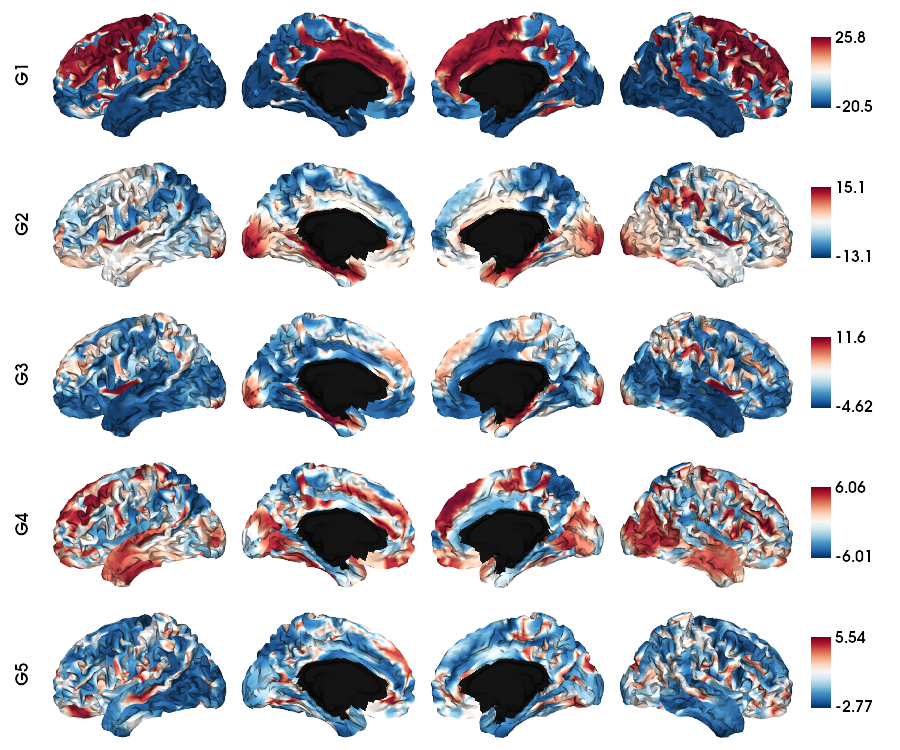

In [69]:
# Calculate the gradients
Ngrad=5
MPC_all, grad = mpc_dm(mMPC, mask_surf, Ngrad=Ngrad, kernel='cosine', sparsity=0.95)

# plot the gradients
labels=['G'+str(x) for x in list(range(1,Ngrad+1))]
plot_hemispheres(MNI_wmL, MNI_wmR, array_name=grad, cmap='RdBu_r', nan_color=(0, 0, 0, 1),
  zoom=1.5, size=(900, 750), embed_nb=True,
  color_bar='right', label_text={'left': labels}, screenshot=False)

In [15]:
from brainspace.gradient import GradientMaps
mean_concatenated_data[np.isnan(mean_concatenated_data)] = 0

# Ask for 10 gradients (default)
gm = GradientMaps(n_components=10, random_state=0)
gm.fit(mMPC)

/data/mica1/03_projects/youngeun/venv/lib/python3.8/site-packages/brainspace-0.1.10-py3.8.egg/brainspace/gradient/embedding.py:70: UserWarning: Affinity is not symmetric. Making symmetric.
  warnings.warn('Affinity is not symmetric. Making symmetric.')
/data/mica1/03_projects/youngeun/venv/lib/python3.8/site-packages/brainspace-0.1.10-py3.8.egg/brainspace/gradient/embedding.py:77: UserWarning: Graph is not fully connected.
  warnings.warn('Graph is not fully connected.')


GradientMaps(random_state=0)

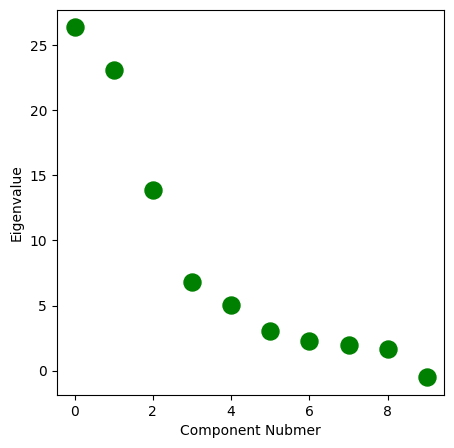

In [16]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, figsize=(5, 5))
ax.scatter(range(gm.lambdas_.size), gm.lambdas_, s=150, c='green')
ax.set_xlabel('Component Nubmer')
ax.set_ylabel('Eigenvalue')

plt.show()

## Blade-like SWM atlas

In [17]:
# Environment variables
surf='fsLR-5k'
out_maps='/host/percy/local_raid/youngeun/LONI/LPBA40.AIR.nifti/JHU-ICBM-SWM/noFA_SWM'
out_surf='/host/percy/local_raid/youngeun/LONI/LPBA40.AIR.nifti/JHU-ICBM-SWM/I_figured_out_SWM/rawdata/micapipe_v0.2.0/sub-MNI152/surf'

# Load MNI white matter surface
MNI_wmL = read_surface(f'{out_surf}/sub-MNI152_hemi-L_space-nativepro_surf-{surf}_label-white.surf.gii', itype='gii')
MNI_wmR = read_surface(f'{out_surf}/sub-MNI152_hemi-R_space-nativepro_surf-{surf}_label-white.surf.gii', itype='gii')

# Load blade metric
bladesL =  nb.load(f'{out_maps}/MNI152_hemi-L_surf-{surf}_label-white_atlas-blades.shape.gii').darrays[0].data
bladesR =  nb.load(f'{out_maps}/MNI152_hemi-L_surf-{surf}_label-white_atlas-blades.shape.gii').darrays[0].data
blades = np.concatenate((bladesL, bladesR), axis=0)

### Resample the labels

In [18]:
for i in range(len(blades)):

    if blades[i] == 21:
        blades[i] = 1
    elif blades[i] == 23:
        blades[i] = 2
    elif blades[i] == 25 or blades[i] == 29 or blades[i] == 31 or blades[i] == 33:
        blades[i] = 3
    elif blades[i] == 27:
        blades[i] = 4
    elif blades[i] == 41:
        blades[i] = 5
    elif blades[i] == 43 or blades[i] == 49:
        blades[i] = 6
    elif blades[i] == 45 or blades[i] == 47 or blades[i] == 81:
        blades[i] = 7
    elif blades[i] == 61 or blades[i] == 63 or blades[i] == 65 or blades[i] == 67 or blades[i] == 89:
        blades[i] = 8
    elif blades[i] == 83 or blades[i] == 85 or blades[i] == 91 or blades[i] == 87:
        blades[i] = 9
    elif blades[i] == 101:
        blades[i] = 10
    elif blades [i] >= 103:
        blades[i] = 0

In [19]:
# Remove the medial wall
blades[blades==0]=np.NaN

# NaNing everything >= than 180
blades[blades>=160]=np.NaN

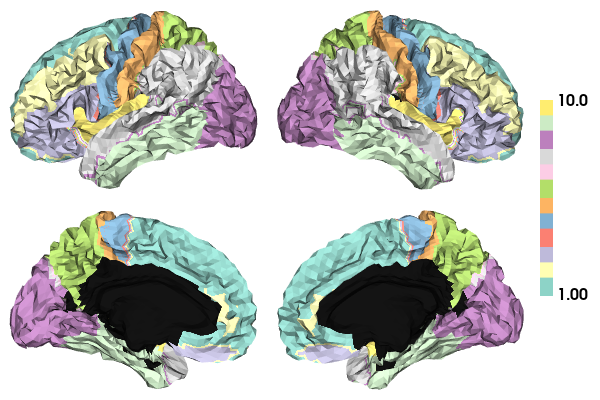

In [20]:
import cmocean
from cmap import Colormap

# plot labels on surface
plot_hemispheres(MNI_wmL, MNI_wmR, array_name=blades, size=(600, 400), zoom=1.6, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), cmap='Set3', transparent_bg=False, color_bar='right', layout_style='grid')

In [21]:
sG1 = grad[0]

# Find indices where mesu_5k has values 1, 2, 3, and 4
indices_1 = np.where(blades == 1)[0]
indices_2 = np.where(blades == 2)[0]
indices_3 = np.where(blades == 3)[0]
indices_4 = np.where(blades == 4)[0]
indices_5 = np.where(blades == 5)[0]
indices_6 = np.where(blades == 6)[0]
indices_7 = np.where(blades == 7)[0]
indices_8 = np.where(blades == 8)[0]
indices_9 = np.where(blades == 9)[0]
indices_10 = np.where(blades == 10)[0]

# Extract values from sgrad corresponding to these indices
values_1 = sG1[indices_1]
values_2 = sG1[indices_2]
values_3 = sG1[indices_3]
values_4 = sG1[indices_4]
values_5 = sG1[indices_5]
values_6 = sG1[indices_6]
values_7 = sG1[indices_7]
values_8 = sG1[indices_8]
values_9 = sG1[indices_9]
values_10 = sG1[indices_10]

/tmp/ipykernel_2584013/3399409346.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(values_2, shade=True, color=custom_colors[0])


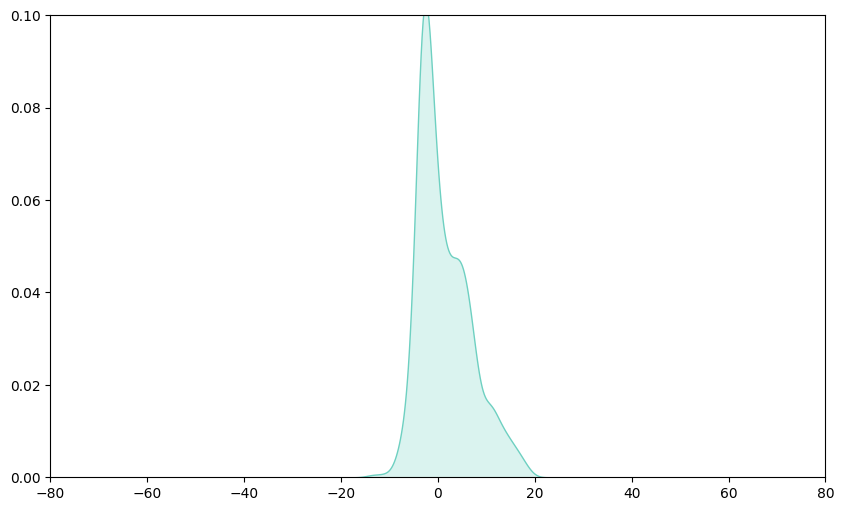

In [93]:
# Define custom colors as RGB tuples (normalized to the range [0, 1])
custom_colors = [(110/255, 208/255, 193/255),  # 1
                 (255/255, 255/255, 162/255),  # 2
                 (186/255, 179/255, 218/255),  # 3
                 (110/255, 169/255, 211/255),  # 4
                 (255/255, 166/255, 74/255),   # 5
                 (163/255, 220/255, 74/255),   # 6
                 (220/255, 213/255, 220/255),  # 7
                 (195/255, 114/255, 186/255),  # 8
                 (193/255, 237/255, 190/255),  # 9
                 (255/255, 236/255, 100/255)]  # 10

# Plot density plots using Seaborn
plt.figure(figsize=(10, 6))
sns.kdeplot(values_2, shade=True, color=custom_colors[0])
plt.xlabel('')
plt.ylabel('')
#plt.title('Density plot of sgrad values for different mesu_5k values')

plt.xlim(-80, 80)
plt.ylim(0, 0.1)
#plt.yticks([])
#plt.xticks([])
#plt.legend()
plt.show()

## Plotting Ridge Graph (Sorted)

In [79]:
!pip install easy_mpl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.4/67.4 kB 1.2 MB/s eta 0:00:002 MB/s eta 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for easy_mpl: filename=easy_mpl-0.21.4-py3-none-any.whl size=63828 sha256=25033a9fed0a63fa64f31ae5ded2e6313bc6a53483c9a2655c90ec12b55fd705
  Stored in directory: /home/bic/yhwang/.cache/pip/wheels/c1/f9/49/b7f26d58f689ded4a48de205af798703facb8f8269b275fb77
Successfully built easy_mpl

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [22]:
import numpy as np
import pandas as pd
from easy_mpl import ridge
import matplotlib.pyplot as plt
from easy_mpl.utils import version_info

### G1 plotting

In [23]:
sG1 = grad[0]

# Find indices where mesu_5k has values 1, 2, 3, and 4
indices_1 = np.where(blades == 1)[0]
indices_2 = np.where(blades == 2)[0]
indices_3 = np.where(blades == 3)[0]
indices_4 = np.where(blades == 4)[0]
indices_5 = np.where(blades == 5)[0]
indices_6 = np.where(blades == 6)[0]
indices_7 = np.where(blades == 7)[0]
indices_8 = np.where(blades == 8)[0]
indices_9 = np.where(blades == 9)[0]
indices_10 = np.where(blades == 10)[0]

# Extract values from sgrad corresponding to these indices
values_1 = sG1[indices_1]
values_2 = sG1[indices_2]
values_3 = sG1[indices_3]
values_4 = sG1[indices_4]
values_5 = sG1[indices_5]
values_6 = sG1[indices_6]
values_7 = sG1[indices_7]
values_8 = sG1[indices_8]
values_9 = sG1[indices_9]
values_10 = sG1[indices_10]

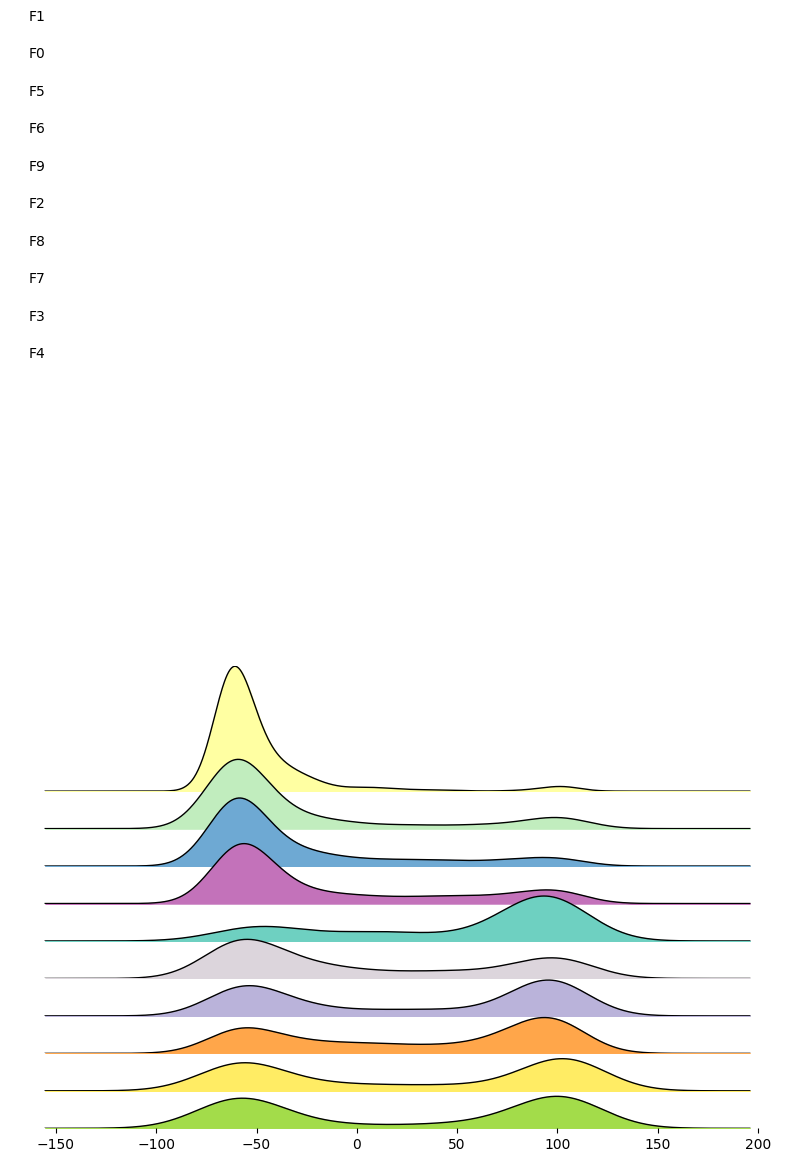

In [24]:
custom4G1 = [(255/255, 255/255, 162/255),  # 2
             (193/255, 237/255, 190/255),  # 9
             (110/255, 169/255, 211/255),  # 4
             (195/255, 114/255, 186/255),  # 8
             (110/255, 208/255, 193/255),  # 1
             (220/255, 213/255, 220/255),  # 7
             (186/255, 179/255, 218/255),  # 3
             (255/255, 166/255, 74/255),   # 5
             (255/255, 236/255, 100/255),   # 10
             (163/255, 220/255, 74/255)]   # 6

_ = ridge([values_1, values_2, values_3, values_4, values_5, values_6, values_7,
          values_8, values_9, values_10], color=custom4G1)

### G2 plotting

In [25]:
sG1 = grad[1]

# Find indices where mesu_5k has values 1, 2, 3, and 4
indices_1 = np.where(blades == 1)[0]
indices_2 = np.where(blades == 2)[0]
indices_3 = np.where(blades == 3)[0]
indices_4 = np.where(blades == 4)[0]
indices_5 = np.where(blades == 5)[0]
indices_6 = np.where(blades == 6)[0]
indices_7 = np.where(blades == 7)[0]
indices_8 = np.where(blades == 8)[0]
indices_9 = np.where(blades == 9)[0]
indices_10 = np.where(blades == 10)[0]

# Extract values from sgrad corresponding to these indices
values_1 = sG1[indices_1]
values_2 = sG1[indices_2]
values_3 = sG1[indices_3]
values_4 = sG1[indices_4]
values_5 = sG1[indices_5]
values_6 = sG1[indices_6]
values_7 = sG1[indices_7]
values_8 = sG1[indices_8]
values_9 = sG1[indices_9]
values_10 = sG1[indices_10]

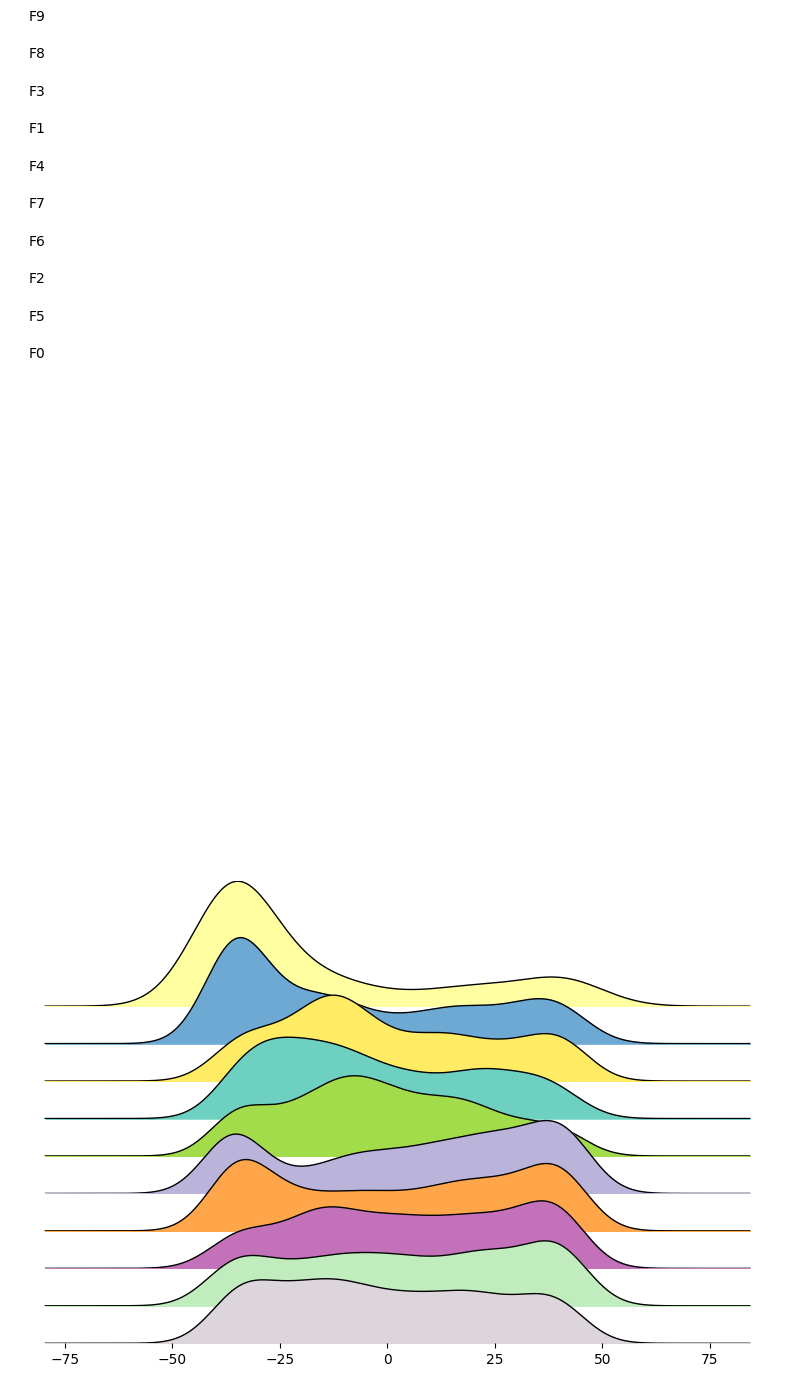

In [26]:
custom4G2 = [(255/255, 255/255, 162/255),  # 2
             (110/255, 169/255, 211/255),  # 4
             (255/255, 236/255, 100/255),   # 10
             (110/255, 208/255, 193/255),  # 1
             (163/255, 220/255, 74/255),   # 6
             (186/255, 179/255, 218/255),  # 3
             (255/255, 166/255, 74/255),   # 5
             (195/255, 114/255, 186/255),  # 8
             (193/255, 237/255, 190/255),  # 9
             (220/255, 213/255, 220/255)]  # 7

_ = ridge([values_1, values_2, values_3, values_4, values_5, values_6, values_7,
          values_8, values_9, values_10], color=custom4G2)

In [110]:
annot_lh= f'/host/percy/local_raid/youngeun/BigBrain_Surface_Parcellations_version-1.0/BigBrain_space/DKT/lh.DKTatlas40.label.gii'
annot_rh= f'/host/percy/local_raid/youngeun/BigBrain_Surface_Parcellations_version-1.0/BigBrain_space/DKT/rh.DKTatlas40.label.gii'
label = np.concatenate((nb.load(annot_lh).darrays[0].data, nb.load(annot_rh).darrays[0].data), axis=0)

In [112]:
label_gii = nb.gifti.GiftiDataArray(label, intent='NIFTI_INTENT_LABEL')
label_image = nb.gifti.GiftiImage(darrays=[label_gii])
nb.save(label_image, '/host/percy/local_raid/youngeun/BigBrain_Surface_Parcellations_version-1.0/BigBrain_space/DKT/DKTatlas40.label.gii')